In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import re 
from nltk.corpus import stopwords 

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split 

import tensorflow as tf 

2025-08-04 16:53:59.273559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754326439.510364      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754326439.579781      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv")


In [4]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [6]:
stop_words = stopwords.words('english')


In [7]:
def process_text(text):
    text = re.sub(r'\d+', ' ', text)
    text = text.split()
    text = " ".join([word for word in text if word.lower().strip() not in stop_words])
    return text

In [8]:
reviews = df['Review'].apply(process_text)


In [9]:
num_words = 10000

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(reviews)

sequences = tokenizer.texts_to_sequences(reviews)

In [10]:
max_seq_length = np.max(list(map(lambda x: len(x), sequences)))

print("Max sequence length:", max_seq_length)

Max sequence length: 1833


In [11]:
inputs = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

In [12]:
inputs

array([[   8,    1,  174, ...,    0,    0,    0],
       [ 139,  136,  262, ...,    0,    0,    0],
       [   8,    9,   76, ...,    0,    0,    0],
       ...,
       [ 139,  733,    8, ...,    0,    0,    0],
       [   1, 3785, 2479, ...,    0,    0,    0],
       [  27, 1156,  187, ...,    0,    0,    0]], dtype=int32)

# Encoding Labels


In [13]:
df['Rating'].value_counts()


Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64

In [14]:
labels = np.array(df['Rating'].apply(lambda x: 1 if x == 5 else 0))


In [15]:
labels

array([0, 0, 0, ..., 0, 0, 0])

# Splitting

In [16]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, train_size=0.7, random_state=100)


# Model Training

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1754326672.266233      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


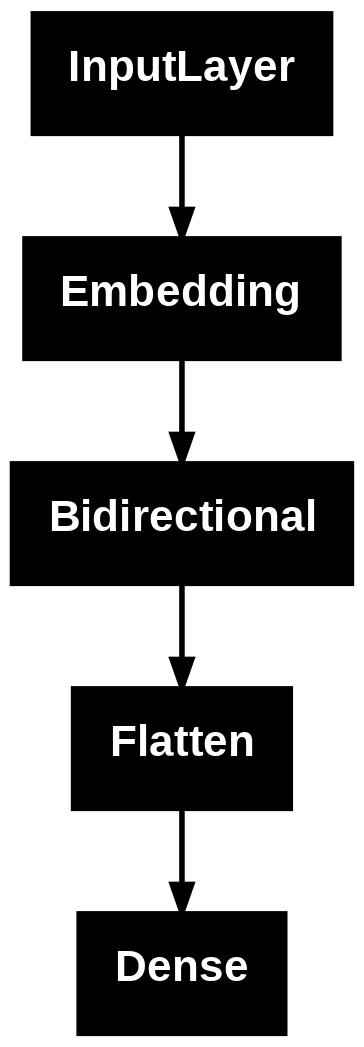

In [17]:
embedding_dim = 128

inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)

gru = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(128, return_sequences=True)
)(embedding)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)


model = tf.keras.Model(inputs, outputs)

tf.keras.utils.plot_model(model)

In [18]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_inputs,
    train_labels,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20


I0000 00:00:1754326689.680248     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


359/359 ━━━━━━━━━━━━━━━━━━━━ 78s 200ms/step - accuracy: 0.6691 - auc: 0.7139 - loss: 0.7674 - val_accuracy: 0.7316 - val_auc: 0.8858 - val_loss: 0.5373
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 199ms/step - accuracy: 0.8654 - auc: 0.9393 - loss: 0.3139 - val_accuracy: 0.7741 - val_auc: 0.8681 - val_loss: 0.4679
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 198ms/step - accuracy: 0.9634 - auc: 0.9934 - loss: 0.1176 - val_accuracy: 0.7560 - val_auc: 0.8496 - val_loss: 0.6881
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 198ms/step - accuracy: 0.9932 - auc: 0.9998 - loss: 0.0270 - val_accuracy: 0.7661 - val_auc: 0.8371 - val_loss: 0.9706


# Results

In [19]:
model.evaluate(test_inputs, test_labels)


193/193 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.7736 - auc: 0.8564 - loss: 0.4893


[0.4841151833534241, 0.77244633436203, 0.860482931137085]